"""
Implements an RNN on a synthetic data set, following the architecture 
described in "Deep Knowledge Tracing" by Chris Piech et al.
The RNN implementation is based on min-char-rnn.py by Andrej Karpathy (@karpathy).
BSD License
"""

In [1]:
# Python libraries
import numpy as np
import theano
import theano.tensor as Tensor
import lasagne
import random
import sys
import csv
import matplotlib.pyplot as plt
# allows plots to show inline in ipython notebook
%matplotlib inline

# our own modules
from utils import *
from visualize import *

data_sets_map = {
    'synth':"syntheticDetailed/naive_c5_q50_s4000_v0.csv",
    'code_org' : "data/hoc_1-9_binary_input.csv"
}

DATA_SET = 'code_org'
DATA_SZ = 500000

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
# Read in the data set
# This function can be moved to utils.py
data_array = np.array(list(csv.reader(open(data_sets_map[DATA_SET],"rb"),delimiter=','))).astype('int')
num_samples = data_array.shape[0]
num_problems = data_array.shape[1]

# time steps is number of problems - 1 because we cannot predict on the last problem.
num_timesteps = num_problems - 1 

# Split data into train and test (half and half)
train_data = data_array[0:num_samples/2,:]
test_data = data_array[num_samples/2:num_samples,:]

In [3]:
# print (num_problems)
# for prob in xrange(num_problems):
#     print ('Train Prob {} : percent correct {}'.format(prob, np.mean(train[:,prob]) ))
#     print ('Test Prob {} : percent correct {}'.format(prob, np.mean(test[:,prob]) ))
# print ('Train : percent correct {}'.format( np.mean(train) ))

num_train = train_data.shape[0]
num_test = test_data.shape[0]

print('Vectorization...')
X_train, next_problem_train, truth_train = vectorize_data(train_data)
X_test, next_problem_test, truth_test = vectorize_data(test_data)
print ("Vectorization done!")

Vectorization...
Vectorization done!


In [6]:
def get_batch(_X, _y, _truth, batch_size):
    # TODO: keep a global i
    # TODO: keep a global num_timesteps and num_problems
    X_batch = _X[i,:,:].reshape((num_timesteps, num_problems * 2))
    y_batch = _y[i,:].reshape((num_timesteps))
    truth_batch = _truth[i,:].reshape((num_problems))
    return X_batch, y_batch, truth_batch

def shuffle_data(X, y, truth):
    pass

In [ ]:
class TimeDenseLayer(Layer):
    """
    TimeDenseLayer(incoming, num_units,
    W=lasagne.init.GlorotUniform(), b=lasagne.init.Constant(0.),
    nonlinearity=lasagne.nonlinearities.rectify, **kwargs)
    A fully connected layer that deals with time step input.
    Parameters
    ----------
    incoming : a :class:`Layer` instance or a tuple
        The layer feeding into this layer, or the expected input shape.
        Will treat the input as of shape [n_sample, n_timestep, n_input]
    num_units : int
        The number of units of the layer
    W : Theano shared variable, expression, numpy array or callable
        Initial value, expression or initializer for the weights.
        These should be a matrix with shape ``(num_inputs, num_units)``.
        See :func:`lasagne.utils.create_param` for more information.
    b : Theano shared variable, expression, numpy array, callable or ``None``
        Initial value, expression or initializer for the biases. If set to
        ``None``, the layer will have no biases. Otherwise, biases should be
        a 1D array with shape ``(num_units,)``.
        See :func:`lasagne.utils.create_param` for more information.
    nonlinearity : callable or None
        The nonlinearity that is applied to the layer activations. If None
        is provided, the layer will be linear.
    """
    def __init__(self, incoming, num_units, W=init.GlorotUniform(),
                 b=init.Constant(0.), nonlinearity=Tensor.nnet.softmax,
                 **kwargs):
        super(DenseLayer, self).__init__(incoming, **kwargs)
        self.nonlinearity = (nonlinearities.identity if nonlinearity is None
                             else nonlinearity)

        self.num_units = num_units

        num_samples = int(self.input_shape[0])
        num_timesteps = int(self.input_shape[1])
        num_inputs = int(np.prod(self.input_shape[2:]))

        self.W = self.add_param(W, (num_inputs, num_units), name="W")
        if b is None:
            self.b = None
        else:
            self.b = self.add_param(b, (num_units,), name="b",
                                    regularizable=False)

    def get_output_shape_for(self, input_shape):
        return (self.num_samples, self.num_timesteps, self.num_units)

    def get_output_for(self, input, **kwargs):
        input_reshaped = Tensor.reshape([self.num_timesteps, self.num_samples, self.num_inputs])
        # TODO: deal with b = None case
        results, updates = theano.scan(lambda x: self.nonlinearity(T.dot(input, self.W) + self.b.dimshuffle('x', 0)),
                                      outputs_info=None,
                                      sequences=[input_reshaped])
        return results

In [27]:
# hyperparameters
hidden_size = 200 # size of hidden layer of neurons
learning_rate = 1e-1
epochs = 2
reg_strength = 0.0
grad_clip = 100

'''
Create a model using Lasagne layering system. The layers are as follows:
 - Input layer: [n_sample, n_time, n_input] -> [n_sample, n_time, n_input]
 - LSTM layer: [n_sample, n_time, n_input] -> [n_sample, n_time, n_hidden]
 - Reshape layer: [n_sample, n_time, n_hidden] -> [n_sample*n_time, n_hidden]
 - Dense layer: [n_sample*n_time, n_hidden] -> [n_sample*n_time, n_output]
 - Output reshape layer: [n_sample*n_time, n_output] -> [n_sample, n_time, n_output]
'''
l_in = lasagne.layers.InputLayer(shape=(None, num_timesteps, num_problems * 2))
l_lstm = lasagne.layers.LSTMLayer(
    l_in, hidden_size, grad_clipping=grad_clip,
    nonlinearity=lasagne.nonlinearities.tanh)
l_reshape = lasagne.layers.ReshapeLayer(l_lstm, (-1, hidden_size))
l_out = lasagne.layers.DenseLayer(l_reshape,
    num_units=num_problems,
    W = lasagne.init.Normal(),
    nonlinearity=lasagne.nonlinearities.sigmoid)
l_pred = lasagne.layers.ReshapeLayer(l_out, (-1, num_timesteps, num_problems))

# pred:for each student, a vector that gives probability of next question being answered correctly
# y: for each student, a one-hot-encoding of shape (num_timesteps, num_problems), indicating which problem the student will do at the next timestep 
# truth: for each student, a vector that indicates for each timestep whether next problem was answered correctly
pred = lasagne.layers.get_output(l_pred)
next_problem = Tensor.imatrix('next_problem')
truth = Tensor.imatrix("truth")

# loss function
pred_probs = Tensor.sum(pred * next_problem, axis = 1)
printstuff = theano.function([pred_probs], pred_probs.shape)
# loss = Tensor.nnet.binary_crossentropy(pred_probs, truth)

# # update function
# print("Computing updates ...")
# all_params = lasagne.layers.get_all_params(l_pred)
# updates = lasagne.updates.adagrad(loss, all_params, learning_rate)

# # training function
# print("Compiling functions ...")
# train = theano.function([l_in.input_var, _next_problem, _truth], loss, updates=updates, allow_input_downcast=True)
# compute_cost = theano.function([l_in.input_var, _next_problem, _truth], loss, allow_input_downcast=True)
# # accuracy function
# print("Compiling done!")


# loss function
# results, updates = theano.scan(lambda output_t, target_t, correctness: 
#                                Tensor.nnet.binary_crossentropy(output_t[target_t], correctness[target_t]),
#                                outputs_info=None,
#                                sequences=[output,target],
#                                non_sequences=correctness)
# cost = results.sum()
# # update function
# print("Computing updates ...")
# all_params = lasagne.layers.get_all_params(l_out)
# updates = lasagne.updates.adagrad(cost, all_params, learning_rate)
# print("Compiling functions ...")
# train = theano.function([l_in.input_var, target, correctness], cost, updates=updates, allow_input_downcast=True)
# compute_cost = theano.function([l_in.input_var, target, correctness], cost, allow_input_downcast=True)
# probs = theano.function([l_in.input_var],output,allow_input_downcast=True)
# print("Compiling done!")

In [30]:
# printstuff = theano.function([x,y], pred_probs)
printstuff(np.array[1,2,3,4])

TypeError: 'builtin_function_or_method' object has no attribute '__getitem__'

In [20]:
losses = []
train_accuracies = []
test_accuracies = []
for e in xrange(epochs):
#     total_acc_train = 0.0
#     total_acc_test = 0.0
#     for i in xrange(num_train):
#         inputs_train, targets_train, correctness_train = extract_x_y_corr_for_sample(X_train, y_train, corr_train)
#         inputs_train.reshape()
#         loss = train(inputs_train, targets_train, correctness_train)
#         smooth_loss = smooth_loss * 0.7 + loss * 0.3
#         losses.append(smooth_loss)
#         ps_train = probs(inputs_train)
#         acc_train = accuracy(ps_train, targets_train, correctness_train)
#         train_accuracies.append(acc_train)

#         if i%print_batch_sz == 0 and i != 0:
#             print ('epoch %d, iter %d, loss: %f, train acc: %f' % (e, i, smooth_loss, acc_train)) 

#         total_acc_train += acc_train
#     total_acc_train /= num_train
    loss = train(X_train, y_train, corr_train)
    # ps_train = probs(X_train)
    # acc_train = accuracy(ps_train, targets_train, correctness_train)
    
#     for i in xrange(num_test):
#         inputs_test, targets_test, correctness_test = extract_x_y_corr_for_sample(X_test, y_test, corr_test)
#         ps_test = probs(inputs_test)
#         acc_test = accuracy(ps_test, targets_test, correctness_test) 
#         test_accuracies.append(acc_test)
#         total_acc_test += acc_test
#     total_acc_test /= num_test
    
#     print ('epoch %d, train acc: %f, test acc: %f' % (e, total_acc_train, total_acc_test)) # print progress
    print ('epoch %d, loss: %f' % (e, loss)) # print progress
                    

TypeError: ('Bad input argument to theano function with name "<ipython-input-19-b15064ddf163>:42"  at index 0(0-based)', 'Wrong number of dimensions: expected 3, got 2 with shape (8, 18).')

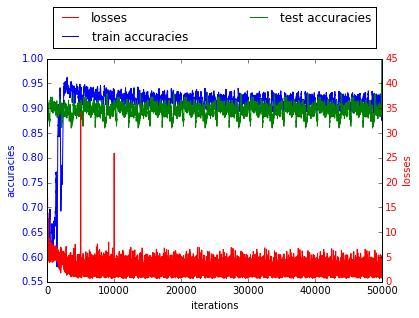

In [24]:
visualize.plot_loss_train_test_acc(losses, train_accuracies, test_accuracies, learning_rate, reg_strength, epochs, num_train)